# Fine tuning SOTA model (RoBERT) from Hugging Face for Document Classification

In this project, we will try to apply the transfer learning technique for NLP task. We will fine tune [BERT](https://arxiv.org/abs/1810.04805) and [RoBERTa](https://arxiv.org/abs/1907.11692) to do text/document classification. Most of the content are taken from [post1](https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/) and [post2](https://medium.com/@armandj.olivares/using-bert-for-classifying-documents-with-long-texts-5c3e7b04573d). In addition, we attempt to make it as general as possible that it can be used for any similar models (thanks to the Transformers library from [hugging face](https://huggingface.co/)) with any dataset by doing just some miner changes. 

In addition, we tried to overcome the limitation of the 512-sequence length of BERT and RoBERTa by using [Longformer](https://arxiv.org/abs/2004.05150) and [RoBERT](https://arxiv.org/abs/1910.10781). It stands for Recurrence over BERT where each ocument is segmented into smaller text and feed each of them to BERT. Then we extract the representation of each text chunk from (pooled_output) and feed the combined representation of each document to LSTM to classify long documents. We will see if this improve the results or overfit the data. We mainly used **python, Transformers, Pytorch, Sklearn**

## Setup


In [1]:
# !pip install -qq -r requirements.txt

In [2]:
# !pip install -qq transformers

In [3]:
# watermark: "An IPython magic extension for printing date and time stamps, version numbers, and hardware information."
# !pip install -q -U watermark

In [4]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers,seaborn,nltk,sklearn,tensorflow

Python implementation: CPython
Python version       : 3.7.9
IPython version      : 7.19.0

numpy       : 1.18.5
pandas      : 1.1.3
torch       : 1.7.0
transformers: 3.4.0
seaborn     : 0.11.0
nltk        : 3.5
sklearn     : 0.0
tensorflow  : 2.3.1



In [5]:
import transformers
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from datetime import datetime


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 10, 6


## Config

We configured this project so we can evaluate different pretrained models with minor changes. All our hyper-parameters are in this section. If you want to use another dataset, check the preprocessing section.

In [6]:
MAX_LEN = 256
BATCH_SIZE = 16
EPOCHS = 4
LEARNING_RATE = 2e-5

"""BERT Model and Tokenizer"""
PRE_TRAINED_MODEL = 'bert-base-cased'
TOKENIZER = transformers.BertTokenizer.from_pretrained(PRE_TRAINED_MODEL)
PT_MODEL = transformers.BertModel.from_pretrained(PRE_TRAINED_MODEL)

"""RoBERTa Model and Tokenizer"""
# PRE_TRAINED_MODEL = 'roberta-base'
# TOKENIZER = transformers.RobertaTokenizer.from_pretrained(PRE_TRAINED_MODEL)
# PT_MODEL = transformers.RobertaModel.from_pretrained(PRE_TRAINED_MODEL)

'RoBERTa Model and Tokenizer'

In [7]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Data Preprocessing



If you use a deferent dataset and reading it as a panda's dataframe, just change the column header that accommodate the content to 'text' and the target column to 'label. Code is provided below.

In [8]:
import os
if not os.path.exists('news.csv'):
    !unzip news.csv.zip

In [10]:
df = pd.read_csv('news.csv')
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [11]:
# df = df.drop(columns=['Unnamed: 0', 'title'])
df = df.drop_duplicates(subset = ['text', 'label'])
print(len(pd.read_csv('news.csv')) - len(df))

275


In [12]:
classes = np.unique(df.label)
classes

array(['FAKE', 'REAL'], dtype=object)

In [13]:
# Label encoding to the target feature
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df.label = le.fit_transform(df.label)
df.head(3)

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",0
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,0
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,1


In [14]:
CLASS_NAMES = np.unique(le.inverse_transform(df.label))
CLASS_NAMES

array(['FAKE', 'REAL'], dtype=object)

In [15]:
df.shape

(6060, 4)

In [16]:
df_train, df_test = train_test_split(df, test_size=0.15, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

df_train.shape, df_val.shape, df_test.shape

((5151, 4), (454, 4), (455, 4))

## Spliting the data to chuncks

Refernce: https://medium.com/@armandj.olivares/using-bert-for-classifying-documents-with-long-texts-5c3e7b04573d

We try extracting just the first 3 chunks. In our experience, using all chunks caused overfitting 


In [17]:
def get_split2(text1):
    l_total = []
    l_parcial = []
    if len(text1.split()) // 200 > 0:
       n = len(text1.split()) // 200
    # to use the whole document delete this if statement
       if n > 3:
            n = 3
    else: 
       n = 1
    for w in range(n):
        if w == 0:
           l_parcial = text1.split()[:250]
           l_total.append(" ".join(l_parcial))
        else:
            l_parcial = text1.split()[w*200:w*200 + 250]
            l_total.append(" ".join(l_parcial))
    return l_total

In [18]:
df_train['text_split'] = df_train['text'].apply(get_split2)
len(df_train['text_split'][0])#, df_train['text_split'][0]

/share/apps/rc/software/Anaconda3/2020.07/envs/deepNLP2020/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


3

In [19]:
df_train.head()

,Unnamed: 0,title,text,label,text_split
2237,9501,Pope Francis Commemorates 500th Anniversary Of...,"November 1, 2016 Pope Francis Commemorates 500...",0,"[November 1, 2016 Pope Francis Commemorates 50..."
4807,7505,Comment on Anonymous: World War 3 Is On The Ho...,Share on Facebook Share on Twitter It has been...,0,[Share on Facebook Share on Twitter It has bee...
637,6437,AG Lynch told FBI Director Comey NOT to go pub...,Posted by Daisy Luther \nAccording to a report...,0,[Posted by Daisy Luther According to a report ...
70,596,Handicapping the Hispanic vote for 2016 GOPers,The last Texas Republican to occupy the Oval O...,1,[The last Texas Republican to occupy the Oval ...
3494,6876,A Barbaric Race Of Underground-Dwelling Giants...,A Barbaric Race Of Underground-Dwelling Giants...,0,[A Barbaric Race Of Underground-Dwelling Giant...


In [20]:
df_val['text_split'] = df_val['text'].apply(get_split2)
# df_val.head()

In [21]:
train_l = []
label_l = []
index_l = []
unnamed_l = []
for idx,row in df_train.iterrows():
    for l in row['text_split']:
        train_l.append(l)
        label_l.append(row['label'])
        index_l.append(idx)
        unnamed_l.append(row['Unnamed: 0'])
        
len(train_l), len(label_l), len(index_l)

(11310, 11310, 11310)

In [22]:
train_df = pd.DataFrame({'id':unnamed_l, 'text':train_l, 'label':label_l})
train_df.head()

,id,text,label
0,9501,"November 1, 2016 Pope Francis Commemorates 500...",0
1,7505,Share on Facebook Share on Twitter It has been...,0
2,7505,documents –here is an example of the latest ba...,0
3,7505,Former Canadian Defense Minister (source) “Eve...,0
4,6437,Posted by Daisy Luther According to a report i...,0


In [23]:
train_df.shape

(11310, 3)

In [24]:
df.shape

(6060, 4)

In [25]:
val_l = []
val_label_l = []
val_index_l = []
unnamed_l = []
for idx,row in df_val.iterrows():
    for l in row['text_split']:
        val_l.append(l)
        val_label_l.append(row['label'])
        val_index_l.append(idx)
        unnamed_l.append(row['Unnamed: 0'])
        
len(val_l), len(val_label_l), len(val_index_l)

(1014, 1014, 1014)

In [26]:
val_df = pd.DataFrame({'id':unnamed_l, 'text':val_l, 'label':val_label_l})
val_df.head()

,id,text,label
0,4571,For many Americans who have long felt threaten...,1
1,4571,in the future.” On Wednesday night and again T...,1
2,4571,"extraordinarily intense campaign, and we’re se...",1
3,7974,Here's something interesting from The Unz Revi...,0
4,7974,"euphemism for mixing races, pushing junk popul...",0


In [27]:
df_test['text_split'] = df_test['text'].apply(get_split2)

In [28]:
test_l = []
test_label_l = []
test_index_l = []
unnamed_l = []
for idx,row in df_test.iterrows():
    for l in row['text_split']:
        test_l.append(l)
        test_label_l.append(row['label'])
        test_index_l.append(idx)
        unnamed_l.append(row['Unnamed: 0'])
        
len(test_l), len(test_label_l), len(test_index_l)

(972, 972, 972)

In [29]:
test_df = pd.DataFrame({'id':unnamed_l, 'text':test_l, 'label':test_label_l})
test_df.head(4)

,id,text,label
0,9413,Erin Brockovich: Millions of Americans' tap wa...,0
1,9413,"heavy metals analysis results for foods, dieta...",0
2,7564,"By Sean Colarossi on Mon, Oct 31st, 2016 at 9:...",0
3,7564,"legislation in the early 1990s. Moreover, the ...",0


## PyTorch Dataset and DataLoader

In [30]:
"""
This class is an extension from torch Dataset class to be able to use the standard pytorch
DataLoader framework to train, validatem and test the model. Here, we used the encode_plus method 
to the hugging face tokenizer. It will do all the tokenization and preprocessing (add <CLS> and <SEP>, 
pad or truncate the text to a max length) and return a dictionary with the token_ids and attention_mask. 
This class will also return the actual text and the true label to help evaluate the model, later.
"""
class NewsDataset(Dataset):

    def __init__(self, news_texts, labels, tokenizer, max_len):
        self.news_texts = news_texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.news_texts)
    
    def __getitem__(self, item):
        news_Text = str(self.news_texts[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            news_Text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt')

        return {
          'news_Text': news_Text,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'labels': torch.tensor(label, dtype=torch.long)}

The tokenizer is doing most of the heavy lifting for us. We also return the review texts, so it'll be easier to evaluate the predictions from our model.

In [31]:
"""
This is a helper function to prepare the dataset and rap it to the pytorch DataLoader
"""
def create_data_loader(df, tokenizer, max_len, batch_size):
    dataset = NewsDataset(
        news_texts=df.text.to_numpy(),
        labels=df.label.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len)

    return DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4)

In [32]:
train_data_loader = create_data_loader(train_df, TOKENIZER, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(val_df, TOKENIZER, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(test_df, TOKENIZER, MAX_LEN, BATCH_SIZE)

Let's have a look at an example batch from the training data loader:

In [33]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['news_Text', 'input_ids', 'attention_mask', 'labels'])

In [34]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['labels'].shape)

torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([16])


## The Classification Model

There are a lot of helpers that make using BERT easy with the Transformers library. For this task, we will use the basic [BertModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) and build our classifier on top of it.

The `last_hidden_state`, which we will not use here since we do classification, is a sequence of hidden states of the last layer of the model. Obtaining the `pooled_output`, what we need, is done by applying the [BertPooler](https://github.com/huggingface/transformers/blob/edf0582c0be87b60f94f41c659ea779876efc7be/src/transformers/modeling_bert.py#L426) on `last_hidden_state`:

In [35]:
"""
This classifier take the input from BertModel last layer (after pooling) and use 
a dropout layer for some regularization and a fully-connected layer for our 
classification output. Note that we're returning the raw output of the last layer 
since it is required for the cross-entropy loss function in PyTorch.
We also return the pooled_output so we can get the featurs (768 vector) during predection,
which will be fed to LSTM

last_hidden_state shape: [1, batch_size, model_last_hidden_state]
pooled_output shape: [1, model_last_hidden_state] 
"""
class NewsClassifier2(nn.Module):

    def __init__(self, n_classes):
        super(NewsClassifier2, self).__init__()
        self.pretrained_model = PT_MODEL
        self.drop = nn.Dropout(p=0.2)
        self.out = nn.Linear(self.pretrained_model.config.hidden_size, n_classes)
    
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.pretrained_model(input_ids=input_ids, attention_mask=attention_mask)
        output = self.drop(pooled_output)
        
        return pooled_output, self.out(output)


This should work like any other PyTorch model. Let's create an instance and move it to the GPU:

In [36]:
model = NewsClassifier2(len(CLASS_NAMES))
model = model.to(device)

We'll move the example batch of our training data to the GPU:

In [37]:
# loading a pretrained model

# model = NewsClassifier2(len(CLASS_NAMES))
# model.load_state_dict(torch.load(PRE_TRAINED_MODEL + '_best_model2.bin'))
# model = model.to(device)

To get the predicted probabilities from our trained model, we'll apply the softmax function to the outputs:

### Training the model

For optimization, we'll use the [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw) optimizer provided by Hugging Face. We'll also use a linear scheduler with no warmup steps:

In [38]:
optimizer = transformers.AdamW(model.parameters(), lr=LEARNING_RATE, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = transformers.get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps)

# We are doing classification. We can directly use CrossEntropyLoss from torch
loss_fn = nn.CrossEntropyLoss().to(device)


Let's continue with writing a helper function for training our model for one epoch:

In [81]:
"""
This is a helper function that for each epoch it go through all the training data,
do the backpropagation and optimization, and finally return the average accuracy 
and loss for that epoch.
"""
def train_epoch(
    model, 
    data_loader, 
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    n_examples
  ):
    model = model.train()

    losses = []
    correct_predictions = 0
    
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["labels"].to(device)

        _, outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [39]:
"""
This is another helper function to evaluate the model on a given data loader.
It's going to used after each epoch
"""

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            _, outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, labels)

            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

Using the previous two function, we will write our training loop. We'll also store the training history (similar to Scikit-Learn Library)

In [40]:
train_df.shape, df_train.shape

((11310, 3), (5151, 5))

In [82]:
%%time

history = defaultdict(list)
best_accuracy = 0
train_accuracy = 0

for epoch in range(EPOCHS):
    current_time = datetime.now()
    print(f'Training Epoch {epoch + 1}/{EPOCHS}')
    print('*' * 20)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,    
        loss_fn, 
        optimizer, 
        device, 
        scheduler, 
        len(train_df))

    print(f'Train loss {train_loss}  ---  Train accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn, 
        device, 
        len(val_df))

    print(f'Val  loss {val_loss}   ---   Val  accuracy {val_acc}')
    print('-' * 60)
    print()

    print("This epoch took time ", datetime.now() - current_time)
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    # Storing the state of the best model, indicated by the highest training and validation accuracy.
    if train_acc > train_accuracy and val_acc >= best_accuracy:
        torch.save(model.state_dict(), PRE_TRAINED_MODEL + '_best_model2.bin')
        train_accuracy = train_acc
        best_accuracy = val_acc

Training Epoch 1/4
********************
Train loss 0.3251081778861509  ---  Train accuracy 0.8720601237842617
Val  loss 0.3063118341815425   ---   Val  accuracy 0.9142011834319527
------------------------------------------------------------

This epoch took time  0:05:09.769730

Training Epoch 2/4
********************
Train loss 0.14303962407124696  ---  Train accuracy 0.9603890362511053
Val  loss 0.2835551250136632   ---   Val  accuracy 0.9230769230769231
------------------------------------------------------------

This epoch took time  0:05:08.241159

Training Epoch 3/4
********************
Train loss 0.07652809177311694  ---  Train accuracy 0.9824049513704686
Val  loss 0.27660044563322117   ---   Val  accuracy 0.9378698224852071
------------------------------------------------------------

This epoch took time  0:05:07.607717

Training Epoch 4/4
********************
Train loss 0.04168559198172337  ---  Train accuracy 0.9906277630415562
Val  loss 0.29799900311377314   ---   Val  acc

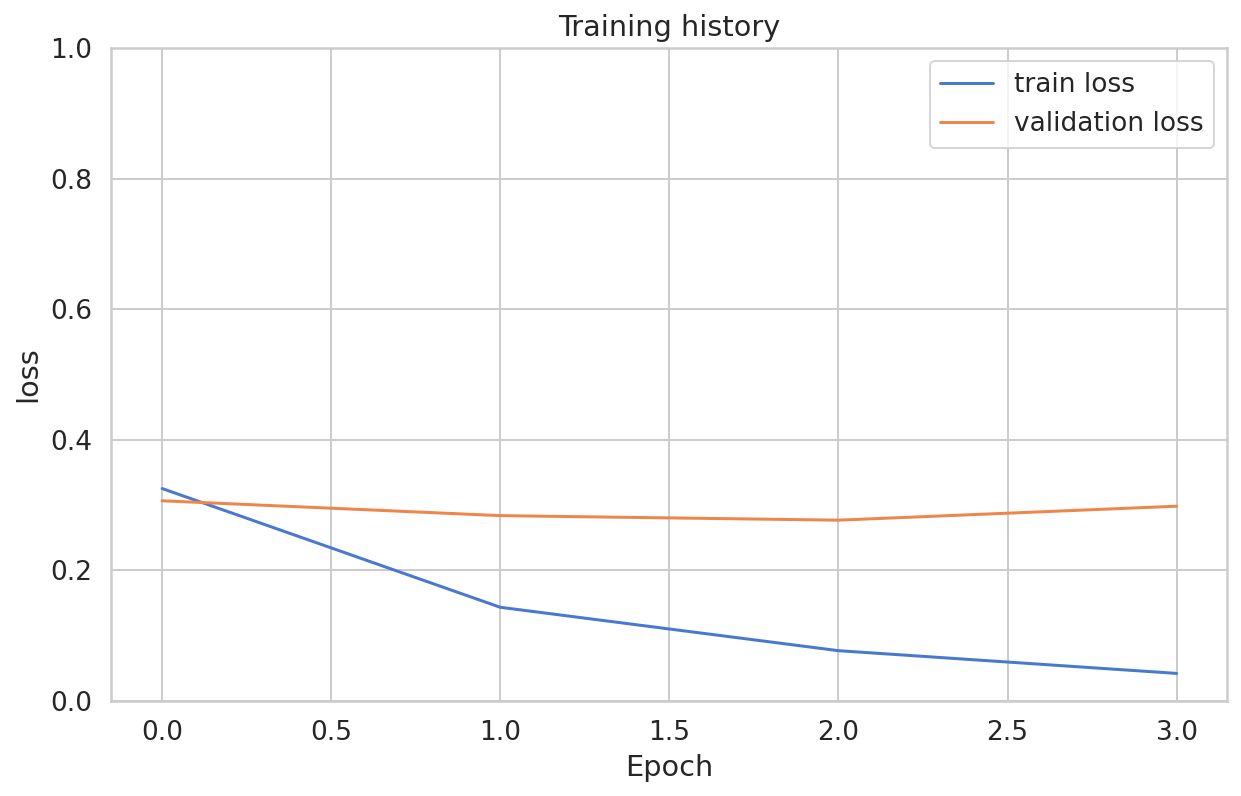

In [83]:
# We can look at the training vs validation losses

plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')

plt.title('Training history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

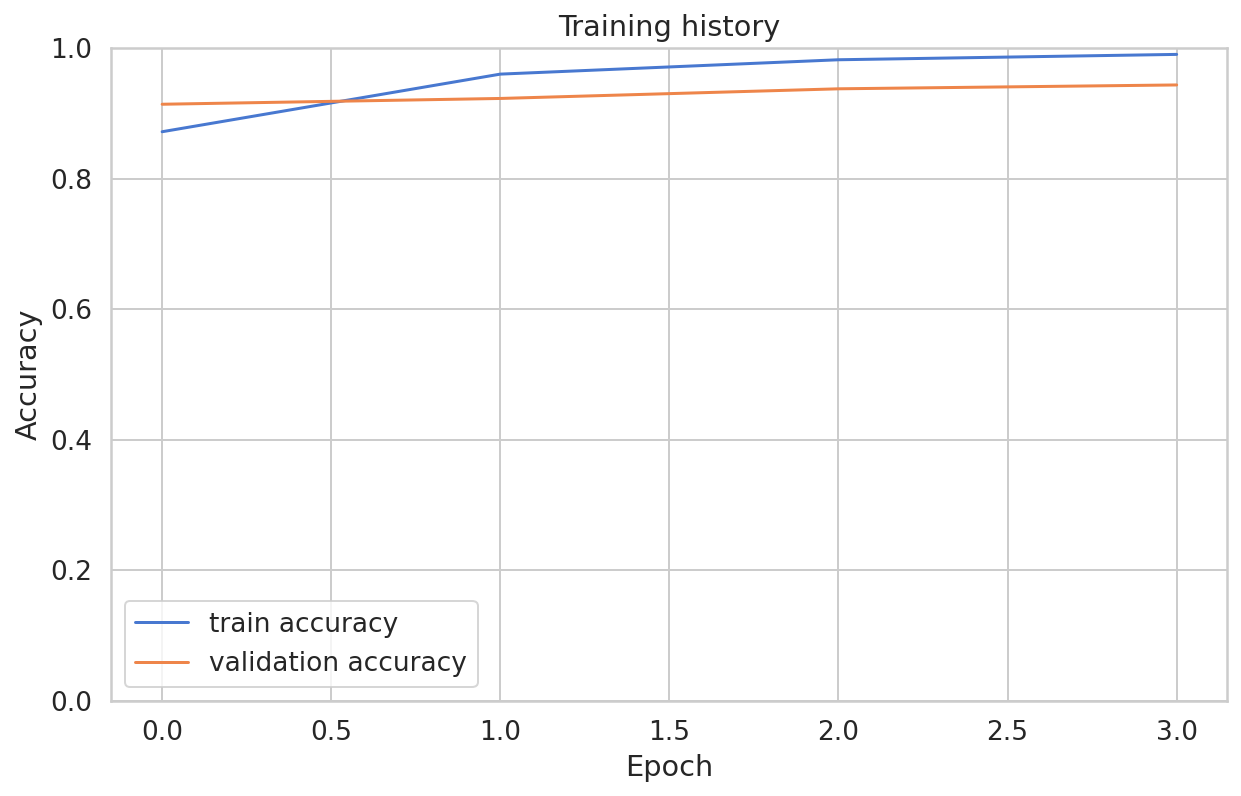

In [84]:
# We can look at the training vs validation accuracy:

plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

### Evaluating the model

So how good is our model on predicting sentiment? Let's start by calculating the accuracy on the test data:

In [85]:
%%time
test_acc, test_loss = eval_model(model, test_data_loader, loss_fn, device, len(test_df))

print('Accuraccy = ' , test_acc.item() * 100, '%')
print('test_loss = ' , test_loss.item())

Accuraccy =  94.0329218106996 %
test_loss =  0.2968254724185156
CPU times: user 3.41 s, sys: 1.46 s, total: 4.87 s
Wall time: 8.75 s


In [87]:
"""
The following is a helper function to get the predictions from our model using 
the test portion of the data.
"""

def get_predictions(model, data_loader):
    model = model.eval()
    
    news_Texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:

            texts = d["news_Text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            _, outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            
            _, preds = torch.max(outputs, dim=1)

            probs = F.softmax(outputs, dim=1)

            news_Texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(labels)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    
    return news_Texts, predictions, prediction_probs, real_values

In [108]:
%%time
y_news_Texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)

CPU times: user 3.16 s, sys: 1.39 s, total: 4.55 s
Wall time: 8.51 s


In [110]:
print(classification_report(y_test, y_pred, target_names=CLASS_NAMES, digits=4)) 

              precision    recall  f1-score   support

        FAKE     0.9347    0.9208    0.9277       404
        REAL     0.9443    0.9542    0.9492       568

    accuracy                         0.9403       972
   macro avg     0.9395    0.9375    0.9384       972
weighted avg     0.9403    0.9403    0.9403       972



In [112]:
# Compute the Matthews correlation coefficient (MCC)

from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_test, y_pred)
print('MCC = ', mcc * 100, '%') 

MCC =  87.69686590666697 %


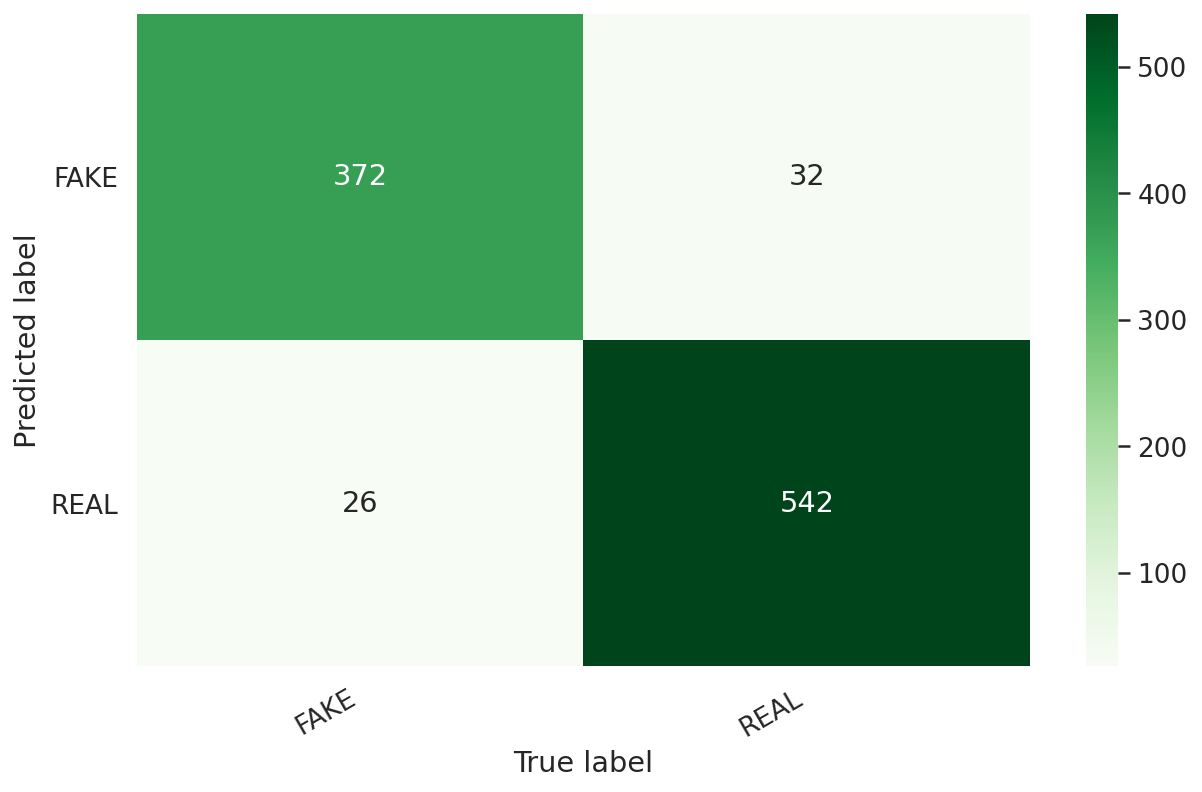

In [114]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Greens")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.xlabel('True label')
    plt.ylabel('Predicted label');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=CLASS_NAMES, columns=CLASS_NAMES)
show_confusion_matrix(df_cm)

## Extracting the features from the pretrained model for LSTM

Next, we will extract the features (pooled_output) for each chunk as a vector/list of 768 item. Then we group the chunks from the same documents together in a single list and store the result back to a data frame. [source](https://medium.com/@armandj.olivares/using-bert-for-classifying-documents-with-long-texts-5c3e7b04573d)

In [88]:
"""
The following is a helper function to get the predictions from our model using 
the test portion of the data.
"""

def get_predictions2(model, data_loader):
    
    model = model.eval()
    
    featurs = []
    
    with torch.no_grad():
        for d in data_loader:

            texts = d["news_Text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            features, _ = model(input_ids=input_ids, attention_mask=attention_mask)
            
            featurs.extend(features)

    featurs = torch.stack(featurs).cpu()

    return featurs

In [89]:
%%time

tr_emb = get_predictions2(model, train_data_loader)

CPU times: user 34.9 s, sys: 13.5 s, total: 48.4 s
Wall time: 1min 32s


In [90]:
len(tr_emb)

11310

In [91]:
tr_emb2 = np.array(tr_emb)

In [92]:
tr_emb2.shape

(11310, 768)

In [93]:
df_train.shape

(5151, 5)

In [94]:
%%time
val_emb = get_predictions2(model, val_data_loader)
val_emb2 = np.array(val_emb)

CPU times: user 3.38 s, sys: 1.41 s, total: 4.8 s
Wall time: 8.85 s


In [95]:
val_emb2.shape, tr_emb2.shape

((1014, 768), (11310, 768))

In [96]:
aux = -1
len_l = 0
train_x = {}
for l, emb in zip(index_l, tr_emb2):
  if l in train_x.keys():
    train_x[l]  =np.vstack([train_x[l], emb])
  else:
    train_x[l] = [emb]

len(train_x.keys())

5151

In [97]:
train_l_final = []
label_l_final = []
for k in train_x.keys():
  train_l_final.append(train_x[k])
  label_l_final.append(df_train.loc[k]['label'])

df_train2 = pd.DataFrame({'emb': train_l_final, 'label': label_l_final, })
df_train2.head()

,emb,label
0,"[[-0.945731, 0.72879815, -0.25952524, 0.881619...",0
1,"[[-0.9534021, 0.72911394, -0.06260341, 0.86017...",0
2,"[[-0.95049626, 0.7188747, -0.24911119, 0.88853...",0
3,"[[0.94207704, -0.64020723, 0.632029, -0.818659...",1
4,"[[-0.9500128, 0.72289205, -0.17348357, 0.87254...",0


In [98]:
df_train.shape, df_train2.shape

((5151, 5), (5151, 2))

In [99]:
df_val.shape

(454, 5)

In [100]:
aux = -1
len_l = 0
val_x = {}

for l, emb in zip(val_index_l, val_emb2):
  if l in val_x.keys():
    val_x[l]  =np.vstack([val_x[l], emb])
  else:
    val_x[l] = [emb]


val_l_final = []
vlabel_l_final = []
for k in val_x.keys():
  val_l_final.append(val_x[k])
  vlabel_l_final.append(df_val.loc[k]['label'])

df_val2 = pd.DataFrame({'emb': val_l_final, 'label': vlabel_l_final})
df_val2.head()

,emb,label
0,"[[0.95559496, -0.67592657, 0.4997365, -0.89497...",1
1,"[[-0.95120627, 0.7253162, -0.18600543, 0.87765...",0
2,"[[-0.9496989, 0.7252827, -0.2421526, 0.8868454...",0
3,"[[-0.9525108, 0.72150457, -0.2672881, 0.895674...",0
4,"[[-0.94409347, 0.7248937, -0.3053733, 0.888977...",0


In [101]:
df_val2.shape

(454, 2)

In [102]:
# import sys
# import numpy as np
# np.set_printoptions(threshold=np.inf)
# np.set_printoptions(threshold=sys.maxsize)

# df_train2.to_csv('train_features3.csv')
# df_val2.to_csv('val_features3.csv')

In [103]:
s = df_train2['emb'][0]

In [104]:
len(s),s

(1,
 [array([-9.45730984e-01,  7.28798151e-01, -2.59525239e-01,  8.81619811e-01,
         -7.50101924e-01,  8.54436457e-01,  6.35593414e-01, -3.60250622e-01,
         -2.04797268e-01, -2.15349197e-01, -3.64403665e-01, -3.14785630e-01,
          2.01160505e-01, -2.70306412e-03,  4.59319763e-02,  9.70695436e-01,
         -9.25221860e-01,  2.55911261e-01,  5.81300437e-01, -5.63607454e-01,
          7.92760372e-01,  7.28558123e-01, -6.11961067e-01, -4.42055076e-01,
         -7.21981406e-01,  5.73332310e-01, -3.14621389e-01, -3.72189403e-01,
          9.60740387e-01, -9.58848536e-01,  5.21228135e-01, -2.06945255e-01,
         -6.66061223e-01,  5.77463508e-01,  6.02419555e-01,  6.15556002e-01,
         -9.82204378e-01, -1.81852654e-01,  6.99141264e-01, -2.46144712e-01,
         -4.06440467e-01,  1.65183380e-01,  4.37984094e-02, -2.55635679e-01,
          6.88092470e-01,  9.33844149e-01,  2.31361434e-01, -8.72721910e-01,
         -7.05055237e-01, -9.88923728e-01, -8.15155149e-01, -2.24703774e

In [105]:
v = []
for i in df_train2['emb']:
    v.append(len(i))
    
max(v), min(v)

(3, 1)

In [106]:
test_emb = get_predictions2(model, test_data_loader)
test_emb2 = np.array(test_emb)

aux = -1
len_l = 0
test_x = {}

for l, emb in zip(test_index_l, test_emb2):
  if l in test_x.keys():
    test_x[l] = np.vstack([test_x[l], emb])
  else:
    test_x[l] = [emb]


test_l_final = []
tlabel_l_final = []
for k in test_x.keys():
  test_l_final.append(test_x[k])
  tlabel_l_final.append(df_test.loc[k]['label'])

df_test2 = pd.DataFrame({'emb': test_l_final, 'label': tlabel_l_final})
df_test2.head()

,emb,label
0,"[[-0.9378104, 0.6701277, -0.8095596, 0.9611596...",0
1,"[[-0.94968396, 0.7328561, -0.19291024, 0.87525...",0
2,"[[0.94089913, -0.63380086, 0.6405652, -0.81864...",1
3,"[[-0.954309, 0.7295908, -0.42569697, 0.9264252...",0
4,"[[-0.9489692, 0.72670144, -0.41275772, 0.92256...",0


In [107]:
# df_test2.to_csv('test_features3.csv')

## LSTM

## References

- [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)
- [RoBERTa: A Robustly Optimized BERT Pretraining Approach](https://arxiv.org/abs/1907.11692)
- [The Illustrated BERT, ELMo, and co.](https://jalammar.github.io/illustrated-bert/)
- [Hierarchical Transformers for Long Document Classification](https://arxiv.org/abs/1910.10781)
- [Using BERT For Classifying Documents with Long Texts](https://medium.com/@armandj.olivares/using-bert-for-classifying-documents-with-long-texts-5c3e7b04573d)
- [How to Fine-Tune BERT for Text Classification?](https://arxiv.org/pdf/1905.05583.pdf)
- [Sentiment Analysis with BERT and Transformers by Hugging Face using PyTorch and Python](https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/)
- [BERT Fine-Tuning Tutorial with PyTorch](https://mccormickml.com/2019/07/22/BERT-fine-tuning/)
- [Huggingface Transformers](https://huggingface.co/transformers/)
- [BERT Explained: State of the art language model for NLP](https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270)